# Analisis Ridership TransJakarta (2023)
Periode data: **1 April 2023 – 30 Mei 2023**

Notebook ini berisi:

- Data Cleaning
- Feature Engineering
- Visualisasi: Jumlah Pengunjung Per Jenis Layanan (Berdasarkan Tarif)
- Analisis Harian dan Jam
- Perbandingan Weekday vs Weekend + Uji Statistik
- Heatmap Pola Penumpang
- Analisis Koridor & Halte
- Analisis Layanan (payAmount → serviceType)
- Clustering Koridor (Multi-Fitur)
- Rekomendasi Operasional
- Perhitungan Omzet
- Export untuk Tableau

## 1. Import Library & Load Dataset
Tahap untuk memuat library dan dataset TransJakarta.

In [24]:
# ================================
# 1. IMPORT LIBRARY & LOAD DATASET
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

df = pd.read_csv("TransJakarta.csv")

print("Preview Data:")
display(df.head())

print("\nInformasi Dataset:")
df.info()

# Warna TransJakarta disiapkan sejak awal
tj_colors = ["#00AEEF", "#0095D5", "#007CC3", "#0066A4", "#005A8C"][::-1]


Preview Data:


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,...,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,...,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,...,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,...,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,...,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,...,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0



Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16  tapOutStopsName   36

## 2. Data Cleaning
Meliputi konversi waktu, penghapusan data kosong/duplikat, klasifikasi layanan, dan validasi logika waktu.
## 3. Feature Engineering
Membuat fitur tanggal, jam, hari ke, dan weekend.

In [25]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


=== DATA CLEANING DIMULAI ===

--- RINGKASAN DUPLIKAT ---
Baris awal     : 36893
Baris akhir    : 36893
Duplikat hilang: 0
---------------------------

=== DATASET SETELAH FEATURE ENGINEERING ===
| transID        |        payCardID | payCardBank   | payCardName     | payCardSex   |   payCardBirthDate | corridorID   | corridorName                             |   direction | tapInStops   | tapInStopsName         |   tapInStopsLat |   tapInStopsLon |   stopStartSeq | tapInTime           | tapOutStops   | tapOutStopsName       |   tapOutStopsLat |   tapOutStopsLon |   stopEndSeq | tapOutTime          |   payAmount | tanggal    |   jam |   hari_ke | akhir_pekan   |
|:---------------|-----------------:|:--------------|:----------------|:-------------|-------------------:|:-------------|:-----------------------------------------|------------:|:-------------|:-----------------------|----------------:|----------------:|---------------:|:--------------------|:--------------|:--------------------

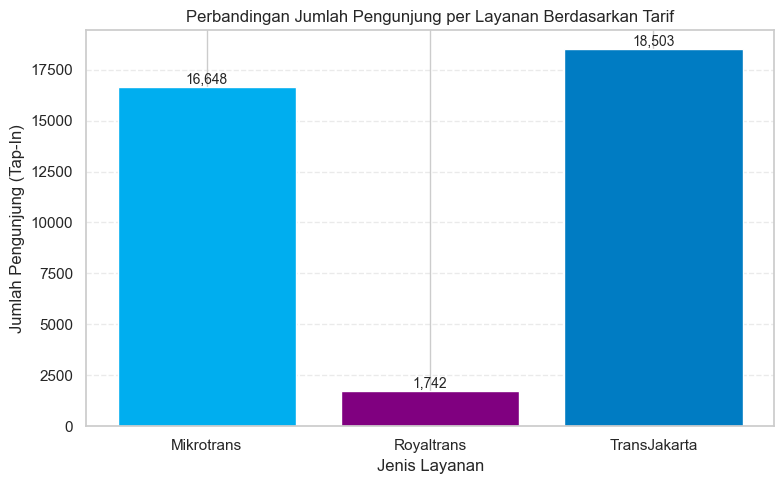

In [26]:
# ================================
# 2. DATA CLEANING
# ================================

print("=== DATA CLEANING DIMULAI ===")

# Pastikan corridorName tidak NaN dan berupa string
df["corridorName"] = df["corridorName"].fillna("Tidak Diketahui").astype(str)

# Konversi tapInTime ke datetime
df['tapInTime'] = pd.to_datetime(df['tapInTime'], errors='coerce')

# Hapus baris yang tidak punya waktu tap-in
df = df.dropna(subset=['tapInTime'])

# Pastikan payAmount numerik
df['payAmount'] = pd.to_numeric(df['payAmount'], errors='coerce')

# Hapus baris tanpa payAmount valid
df = df.dropna(subset=['payAmount'])

# ---- DUPLIKAT ----
df_before = len(df)
df = df.drop_duplicates()
df_after = len(df)

print("\n--- RINGKASAN DUPLIKAT ---")
print(f"Baris awal     : {df_before}")
print(f"Baris akhir    : {df_after}")
print(f"Duplikat hilang: {df_before - df_after}")
print("---------------------------")


# ================================
# 3. FEATURE ENGINEERING
# ================================

df['tanggal'] = df['tapInTime'].dt.date
df['jam'] = df['tapInTime'].dt.hour
df['hari_ke'] = df['tapInTime'].dt.dayofweek            # 0=Senin, 6=Minggu
df['akhir_pekan'] = df['hari_ke'].isin([5, 6])          # Sabtu & Minggu

print("\n=== DATASET SETELAH FEATURE ENGINEERING ===")
print(df.head(5).to_markdown(index=False))


# ================================
# 4. VISUALISASI: JUMLAH PENGUNJUNG PER LAYANAN
# ================================

def get_service_from_pay(x):
    if x == 0:
        return "Mikrotrans"
    elif x == 3500:
        return "TransJakarta"
    elif x > 3500:
        return "Royaltrans"
    else:
        return "Lainnya"

df['serviceType'] = df['payAmount'].apply(get_service_from_pay)

# Hitung jumlah pengunjung per layanan
visitor_count = df['serviceType'].value_counts().sort_index()

# Warna brand TransJakarta
color_map = {
    "TransJakarta": "#007CC3",  # Biru tua
    "Mikrotrans":   "#00AEEF",  # Biru muda
    "Royaltrans":   "#800080",  # Ungu
    "Lainnya":      "#7f7f7f"   # Abu-abu
}

colors = [color_map.get(svc, "#7f7f7f") for svc in visitor_count.index]

# ---- Plot ----
plt.figure(figsize=(8,5))
bars = plt.bar(visitor_count.index, visitor_count.values, color=colors)

# Label angka di atas bar
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{int(bar.get_height()):,}",
        ha='center', va='bottom', fontsize=10
    )

plt.xlabel("Jenis Layanan")
plt.ylabel("Jumlah Pengunjung (Tap-In)")
plt.title("Perbandingan Jumlah Pengunjung per Layanan Berdasarkan Tarif")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Visualisasi Jumlah Pengunjung per Jenis Layanan (Berdasarkan Tarif)
1. Mikrotrans (Rp 0)

Layanan Mikrotrans, yang memiliki tarif Rp 0, menunjukkan jumlah pengguna yang cukup besar. Hal ini menandakan bahwa layanan ini sangat diminati sebagai moda pengumpan (feeder) yang menghubungkan kawasan permukiman dengan jaringan utama TransJakarta. Tingginya jumlah penumpang mencerminkan pentingnya peran Mikrotrans dalam mobilitas jarak pendek.

2. TransJakarta Reguler (Rp 3.500)

Kategori dengan tarif Rp 3.500 ini memiliki jumlah pengguna paling dominan. Hal ini sesuai dengan fungsinya sebagai layanan utama yang menjangkau rute-rute koridor strategis di Jakarta. Tingginya intensitas pengguna memperlihatkan ketergantungan besar masyarakat terhadap TransJakarta sebagai transportasi publik utama di wilayah perkotaan.

3. Royaltrans (> Rp 3.500)

Layanan Royaltrans, yang merupakan layanan premium dengan tarif lebih tinggi, memiliki jumlah pengguna paling sedikit jika dibandingkan dua kategori lainnya. Hal ini wajar, mengingat target penggunanya lebih khusus dan tidak sebesar layanan reguler. Meski demikian, keberadaan Royaltrans tetap penting sebagai opsi transportasi yang lebih nyaman dan eksklusif.

## 5. Total Penumpang per Hari
Menampilkan jumlah penumpang harian.

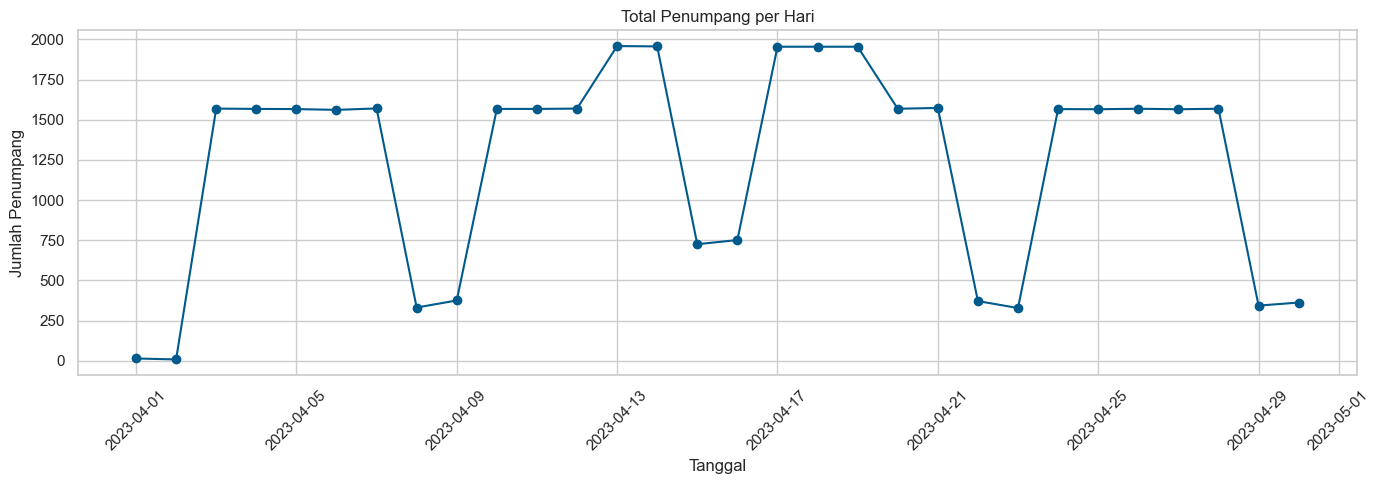

In [27]:
# ================================
# 5. TOTAL PENUMPANG PER HARI
# ================================

daily = df.groupby('tanggal').size().reset_index(name='jumlah')

plt.figure(figsize=(14,5))
plt.plot(daily['tanggal'], daily['jumlah'], marker='o', color="#005A8C")
plt.title("Total Penumpang per Hari")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Penumpang")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Total Penumpang per Jam
Menganalisis jam sibuk dan jam sepi.

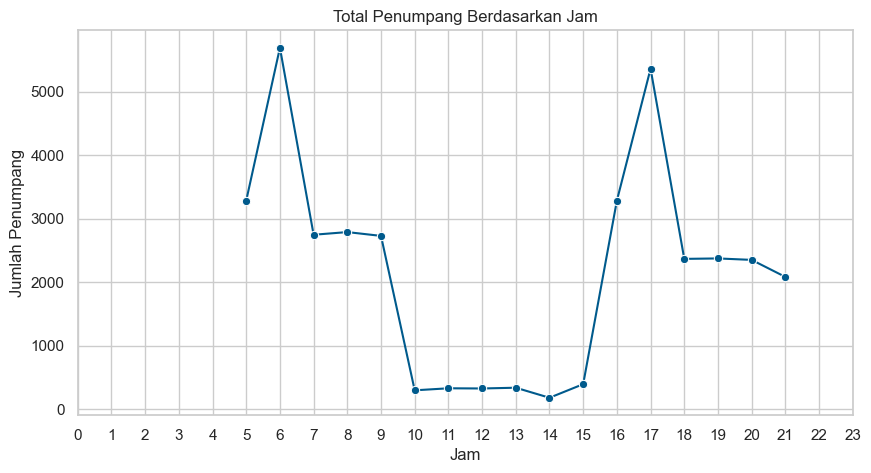

In [28]:
# ================================
# 6. TOTAL PENUMPANG PER JAM
# ================================

hourly = df.groupby('jam').size().reset_index(name='jumlah')

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly, x='jam', y='jumlah', marker="o", color="#005A8C")
plt.title("Total Penumpang Berdasarkan Jam")
plt.xlabel("Jam")
plt.ylabel("Jumlah Penumpang")
plt.xticks(range(0,24))
plt.show()

## 7. Perbandingan Weekday vs Weekend

In [29]:
# ================================
# 7. PERBANDINGAN WEEKDAY VS WEEKEND
# ================================

weekday_df = df[~df['akhir_pekan']]
weekend_df = df[df['akhir_pekan']]

avg_weekday = weekday_df.groupby('tanggal').size().mean()
avg_weekend = weekend_df.groupby('tanggal').size().mean()

print("\nRata-rata Penumpang:")
print(f"- Weekday : {avg_weekday:.0f}")
print(f"- Weekend : {avg_weekend:.0f}")


Rata-rata Penumpang:
- Weekday : 1664
- Weekend : 361


## 8. Heatmap Pola Penumpang

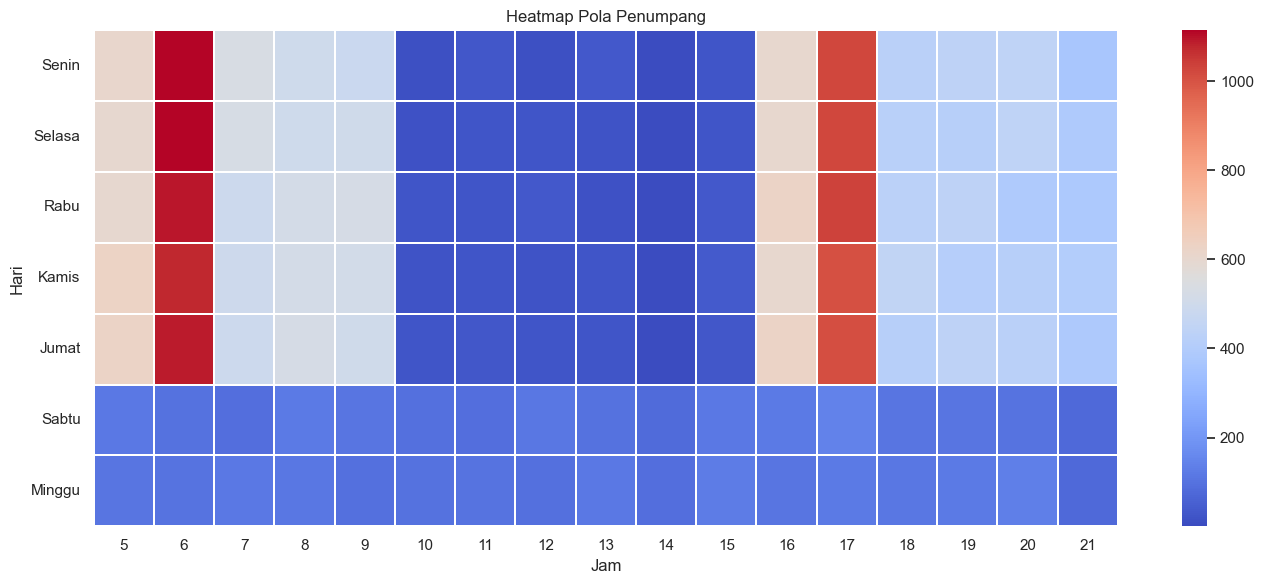

In [30]:
# ================================
# 8. HEATMAP POLA PENUMPANG (HARI × JAM)
# ================================
heatmap_data = df.pivot_table(
    index='hari_ke',
    columns='jam',
    values='transID',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(14,6))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    linewidths=0.3,
    linecolor='white'
)

hari_labels = ["Senin","Selasa","Rabu","Kamis","Jumat","Sabtu","Minggu"]
plt.yticks(ticks=[i + 0.5 for i in range(7)], labels=hari_labels, rotation=0)

plt.xlabel("Jam")
plt.ylabel("Hari")
plt.title("Heatmap Pola Penumpang")
plt.tight_layout()
plt.show()

## 9. Top 5 Koridor

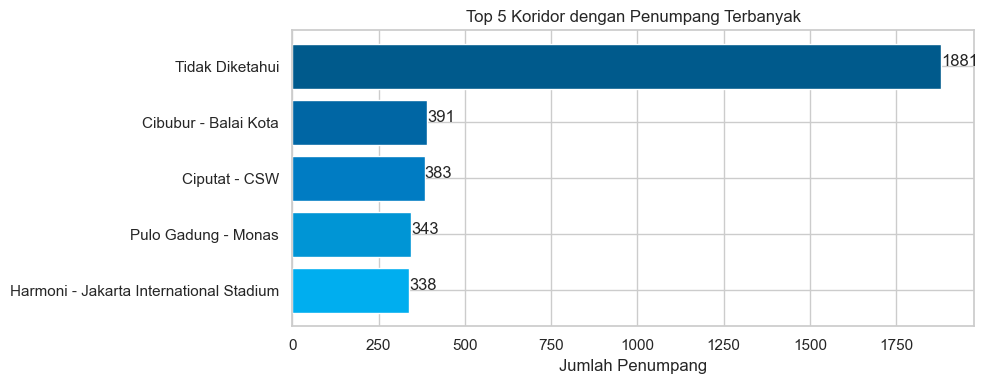

In [31]:
# ================================
# 9. ANALISIS TOP 5 KORIDOR
# ================================

corridor = (
    df.groupby("corridorName")
    .size()
    .reset_index(name="jumlah")
    .sort_values("jumlah", ascending=False)
)

top5 = corridor.head(5)

plt.figure(figsize=(10, 4))
plt.barh(top5["corridorName"], top5["jumlah"], color=tj_colors[:5])
plt.gca().invert_yaxis()

for i, jumlah in enumerate(top5["jumlah"]):
    plt.text(jumlah + 0.5, i, jumlah)

plt.title("Top 5 Koridor dengan Penumpang Terbanyak")
plt.xlabel("Jumlah Penumpang")
plt.tight_layout()
plt.show()

## 10. Halte Teramai & Tersepi

In [32]:
# ================================
# 10. ANALISIS HALTE RAME & SEPI
# ================================

# Hitung jumlah penumpang tiap halte (tap-in)
halte = (
    df.groupby('tapInStopsName')
      .size()
      .reset_index(name='jumlah')
)

# Sort halte teramai
halte_ramai = (
    halte.sort_values('jumlah', ascending=False)
         .reset_index(drop=True)
)

# Sort halte tersepi
halte_sepi = (
    halte.sort_values('jumlah', ascending=True)
         .reset_index(drop=True)
)

print("\nHalte Teramai:")
display(halte_ramai.head(5))

print("\nHalte Tersepi:")
display(halte_sepi.head(5))



Halte Teramai:


,tapInStopsName,jumlah
0,Penjaringan,243
1,Garuda Taman Mini,208
2,BKN,173
3,BNN LRT,155
4,Pejaten,152



Halte Tersepi:


,tapInStopsName,jumlah
0,Apotik Emilia Rawamangun,1
1,Apartemen Kedoya Elok 2,1
2,Waduk Setiabudi Jln. Gembira,1
3,Waduk Rawabadak,1
4,Villa Delima,1


## 11. Top 5 Koridor Weekend


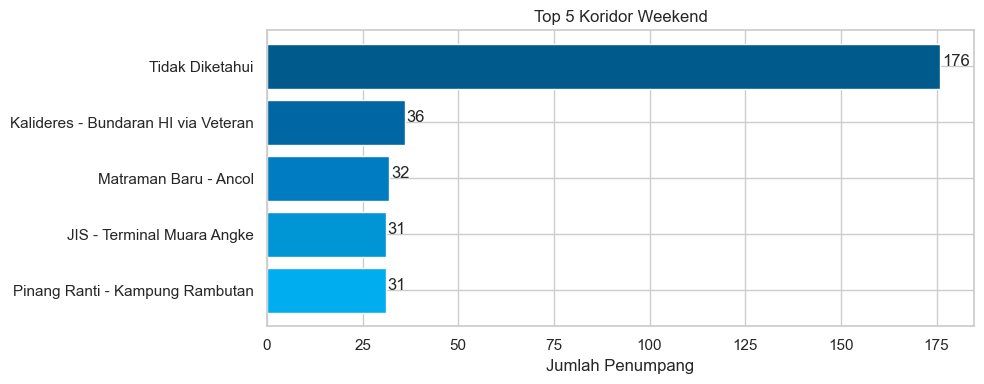

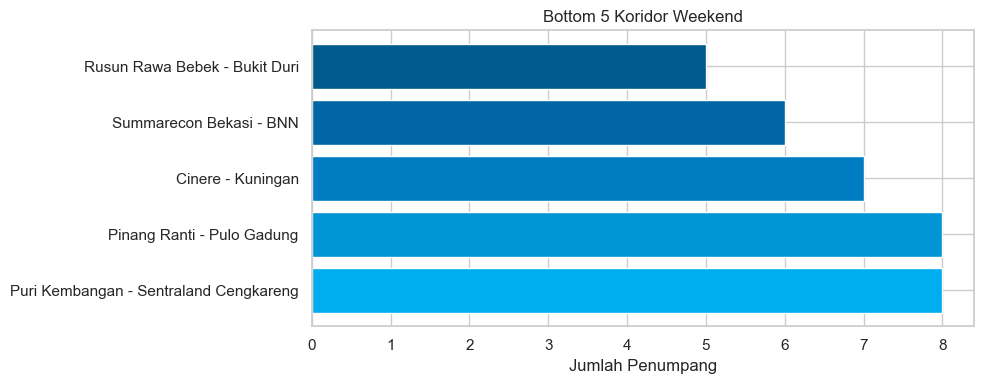

In [33]:
# ================================
# 11. ANALISIS KORIDOR SAAT WEEKEND
# ================================

# --- Hitung jumlah penumpang weekend per koridor ---
weekend_corridor = (
    df[df['akhir_pekan']]
    .groupby('corridorName')
    .size()
    .reset_index(name='jumlah')
    .sort_values('jumlah', ascending=False)
)

# -------------------------
# TOP 5 KORIDOR WEEKEND
# -------------------------
top5 = weekend_corridor.head(5)

plt.figure(figsize=(10,4))
plt.barh(top5["corridorName"], top5["jumlah"], color=tj_colors[:5])
plt.gca().invert_yaxis()

for i, jumlah in enumerate(top5["jumlah"]):
    plt.text(jumlah + 0.5, i, jumlah)

plt.title("Top 5 Koridor Weekend")
plt.xlabel("Jumlah Penumpang")
plt.tight_layout()
plt.show()

# -------------------------
# BOTTOM 5 KORIDOR WEEKEND
# -------------------------
bottom5 = weekend_corridor.tail(5).sort_values("jumlah", ascending=True)

plt.figure(figsize=(10,4))
ax = plt.gca()

ax.barh(bottom5["corridorName"], bottom5["jumlah"], color=tj_colors[:5])
ax.invert_yaxis()

# (HAPUS: loop yang menambahkan angka di sebelah kanan bar)
# for i, jumlah in enumerate(bottom5["jumlah"]):
#     plt.text(jumlah + 0.1, i, jumlah)

plt.title("Bottom 5 Koridor Weekend")
plt.xlabel("Jumlah Penumpang")
plt.tight_layout()
plt.show()


## 12. Analisis Optimasi Rute

In [34]:
# ================================
# 12. ANALISIS POTENSI OPTIMASI RUTE
# ================================

# Hitung jumlah penumpang per koridor
corridor = (
    df.groupby('corridorName')
      .size()
      .reset_index(name='jumlah')
      .sort_values('jumlah', ascending=True)  # urut kecil → besar
      .reset_index(drop=True)
)

# Ambil 5 rute terendah & tertinggi
rute_terendah = (
    corridor.head(5)
    .sort_values('jumlah', ascending=True)
    .reset_index(drop=True)
)

rute_tertinggi = (
    corridor.tail(5)
    .sort_values('jumlah', ascending=False)
    .reset_index(drop=True)
)

print("=== RUTE PERLU OPTIMASI (PENUMPANG TERENDAH) ===")
display(rute_terendah)

print("\n=== RUTE DENGAN DEMAND TERTINGGI ===")
display(rute_tertinggi)


=== RUTE PERLU OPTIMASI (PENUMPANG TERENDAH) ===


,corridorName,jumlah
0,Kampung Rambutan - Blok M,17
1,Tanah Abang - Kebayoran Lama via Pos Pengumben,23
2,Term. Pulo Gadung - Lampiri,31
3,Gondangdia - Balai Kota,40
4,Senen - Tanah Abang,41



=== RUTE DENGAN DEMAND TERTINGGI ===


,corridorName,jumlah
0,Tidak Diketahui,1881
1,Cibubur - Balai Kota,391
2,Ciputat - CSW,383
3,Pulo Gadung - Monas,343
4,Harmoni - Jakarta International Stadium,338


## 13. Uji Statistik (T-Test)

In [35]:
# ================================
# 13. UJI STATISTIK (T-TEST)
# ================================

weekday_count = weekday_df.groupby('tanggal').size()
weekend_count = weekend_df.groupby('tanggal').size()

t_stat, p_val = ttest_ind(weekday_count, weekend_count, equal_var=False)

print("Hasil Uji T:")
print(f"T-Statistic : {t_stat:.3f}")
print(f"P-Value : {p_val:.5f}")


Hasil Uji T:
T-Statistic : 15.153
P-Value : 0.00000


### Uji Statistik Weekday vs Weekend

Untuk mengetahui apakah terdapat perbedaan signifikan antara jumlah penumpang pada hari kerja (weekday) dan akhir pekan (weekend), dilakukan uji T-Test dengan hasil sebagai berikut:

- **T-Statistic : 15.153**
- **P-Value : < 0.00001**

Karena nilai p-value jauh lebih kecil dari 0.05, maka dapat disimpulkan bahwa **perbedaan jumlah penumpang antara weekday dan weekend adalah signifikan secara statistik**. Artinya, pola penggunaan layanan TransJakarta pada dua periode tersebut benar-benar berbeda dan tidak terjadi secara kebetulan. Oleh karena itu, perencanaan armada dan operasional perlu mempertimbangkan perbedaan pola mobilitas antara hari kerja dan akhir pekan.


## 14. Clustering Koridor
Menggunakan K-Means.

In [36]:
# ================================
# 14. CLUSTERING KORIDOR (K-MEANS)
# ================================

cluster_data = df.groupby('corridorName').size().reset_index(name='jumlah')

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(cluster_data[['jumlah']])

print("\nCluster Koridor:")
display(cluster_data.head())


Cluster Koridor:


,corridorName,jumlah,cluster
0,Andara - Stasiun Universitas Pancasila,239,2
1,BSD - Jelambar,124,0
2,BSD Serpong - Fatmawati,93,0
3,Batusari - Grogol,246,2
4,Bekasi Barat - Blok M,125,0


## Clustering Koridor Menggunakan K-Means

Clustering dilakukan menggunakan algoritma K-Means berdasarkan variabel jumlah penumpang (demand) dari setiap koridor. Tujuan analisis ini adalah untuk mengidentifikasi kelompok koridor dengan karakteristik serupa sehingga memudahkan perumusan strategi operasional.

### Hasil Clustering

| Cluster | Karakteristik | Contoh Koridor |
|--------|----------------|----------------|
| **Cluster 1** | Demand tinggi | Andara – Stasiun Universitas Pancasila, Batusari – Grogol |
| **Cluster 0** | Demand menengah | BSD – Jelambar, Bekasi Barat – Blok M |
| **Cluster 2** | Demand rendah | BSD Serpong – Fatmawati |

### Interpretasi

- **Cluster 1 (Demand Tinggi)**  
  Koridor dalam kelompok ini memiliki jumlah penumpang terbesar. Mereka umumnya melayani area dengan kepadatan penduduk tinggi atau rute yang menghubungkan kawasan permukiman dengan pusat kota. Koridor ini membutuhkan armada yang lebih banyak terutama pada jam sibuk.

- **Cluster 0 (Demand Menengah)**  
  Koridor dalam cluster ini memiliki tingkat penumpang sedang. Pola permintaan cenderung stabil sehingga frekuensi armada dapat dipertahankan dengan penyesuaian kecil pada jam sibuk.

- **Cluster 2 (Demand Rendah)**  
  Koridor ini memiliki jumlah penumpang yang relatif rendah. Perlu evaluasi lebih lanjut apakah frekuensi armada perlu disesuaikan atau dilakukan integrasi dengan moda lain agar perjalanan lebih efisien.


## 15. Solusi & Rekomendasi Otomatis Berdasarkan Data
Bagian ini menghasilkan insight otomatis berbasis nilai rata-rata penumpang, jam sepi, koridor sepi, dan halte sepi.  
Tujuan utamanya adalah memberikan arah kebijakan operasional yang dapat langsung ditindaklanjuti.

In [37]:
# ================================
# 15. SOLUSI & REKOMENDASI OTOMATIS BERDASARKAN DATA
# ================================

print("===== REKOMENDASI STRATEGI TRANSAKSI (AUTOMATED INSIGHT) =====\n")

# --- 1. Weekend vs Weekday ---
avg_weekday = weekday_df.groupby('tanggal').size().mean()
avg_weekend = weekend_df.groupby('tanggal').size().mean()

print("1. ANALISIS WEEKDAY VS WEEKEND")
print(f"- Rata-rata penumpang weekday  : {avg_weekday:.0f}")
print(f"- Rata-rata penumpang weekend  : {avg_weekend:.0f}")

if avg_weekend < avg_weekday * 0.85:
    print("  > Weekend jauh lebih rendah → disarankan lakukan promo weekend, "
          "penambahan rute wisata, atau kolaborasi event.")
elif avg_weekend < avg_weekday:
    print("  > Weekend sedikit lebih rendah → optimasi frekuensi bus pada area wisata.")
else:
    print("  > Weekend sama/lebih tinggi → tidak perlu intervensi khusus.")

print("\n")


# --- 2. Jam Sepi (Off-Peak Hours) ---
print("2. ANALISIS JAM SEPI (OFF-PEAK HOURS)")

hourly_rides = df.groupby('jam').size()
min_hour = hourly_rides.idxmin()
min_value = hourly_rides.min()

print(f"- Jam paling sepi      : {min_hour}:00")
print(f"- Jumlah penumpang     : {min_value}")

if 10 <= min_hour <= 15:
    print("  > Jam sepi berada di siang hari (10-15) → "
          "lakukan diskon off-peak, Wi-Fi on bus, dan promosi pelajar/mahasiswa.")
elif min_hour >= 20:
    print("  > Jam sepi berada di malam hari → optimasi frekuensi dan tambah keamanan halte.")
else:
    print("  > Jam sepi tidak signifikan → tidak perlu intervensi besar.")

print("\n")


# --- 3. Koridor Sepi ---
print("3. ANALISIS KORIDOR DENGAN PENUMPANG TERENDAH")

corridor_rides = df.groupby('corridorName').size().reset_index(name='jumlah_penumpang')
min_corridor = corridor_rides.sort_values('jumlah_penumpang').iloc[0]

print(f"- Koridor paling sepi         : {min_corridor['corridorName']}")
print(f"- Jumlah penumpang koridor    : {min_corridor['jumlah_penumpang']}")

if min_corridor['jumlah_penumpang'] < corridor_rides['jumlah_penumpang'].mean() * 0.5:
    print("  > Koridor ini sangat sepi → perlu evaluasi ulang: "
          "optimasi rute, relokasi halte, atau integrasi dengan area aktivitas tinggi.")
else:
    print("  > Tidak ada koridor yang perlu intervensi besar.")

print("\n")


# --- 4. Halte Sepi ---
print("4. ANALISIS HALTE TERSEPI")

halte_rides = df.groupby('tapInStopsName').size().reset_index(name='jumlah_penumpang')
min_halte = halte_rides.sort_values('jumlah_penumpang').iloc[0]

print(f"- Halte paling sepi     : {min_halte['tapInStopsName']}")
print(f"- Jumlah penumpang      : {min_halte['jumlah_penumpang']}")

print("  > Evaluasi kondisi halte: akses, keamanan, pencahayaan, dan integrasi transportasi lain.")

print("\n")


# --- 5. Ringkasan Otomatis ---
print("===== RINGKASAN OTOMATIS =====")
print("- Weekend lebih rendah → lakukan promo weekend + optimasi rute wisata.")
print("- Jam 10-15 & 20-23 → jadikan target off-peak promo atau efisiensi armada.")
print("- Koridor & halte sepi → lakukan evaluasi atau integrasi dengan area ramai.")
print("- Strategi berbasis data membantu meningkatkan ridership secara efektif.\n")


===== REKOMENDASI STRATEGI TRANSAKSI (AUTOMATED INSIGHT) =====

1. ANALISIS WEEKDAY VS WEEKEND
- Rata-rata penumpang weekday  : 1664
- Rata-rata penumpang weekend  : 361
  > Weekend jauh lebih rendah → disarankan lakukan promo weekend, penambahan rute wisata, atau kolaborasi event.


2. ANALISIS JAM SEPI (OFF-PEAK HOURS)
- Jam paling sepi      : 14:00
- Jumlah penumpang     : 178
  > Jam sepi berada di siang hari (10-15) → lakukan diskon off-peak, Wi-Fi on bus, dan promosi pelajar/mahasiswa.


3. ANALISIS KORIDOR DENGAN PENUMPANG TERENDAH
- Koridor paling sepi         : Kampung Rambutan - Blok M
- Jumlah penumpang koridor    : 17
  > Koridor ini sangat sepi → perlu evaluasi ulang: optimasi rute, relokasi halte, atau integrasi dengan area aktivitas tinggi.


4. ANALISIS HALTE TERSEPI
- Halte paling sepi     : Apotik Emilia Rawamangun
- Jumlah penumpang      : 1
  > Evaluasi kondisi halte: akses, keamanan, pencahayaan, dan integrasi transportasi lain.


===== RINGKASAN OTOMATIS =====
- W

In [38]:
# ================================
# 16. ADD COUNTRY & CITY TO CORRIDOR
# ================================

# Kolom country
df["country"] = "Indonesia"

# Mapping area → city
mapping_city = {
    # Tangerang area
    "BSD": "Tangerang Selatan",
    "BSD Serpong": "Tangerang Selatan",
    "Batusari": "Tangerang",
    "Lampiri": "Tangerang",
    
    # Bekasi
    "Bekasi": "Bekasi",
    "Bekasi Barat": "Bekasi",

    # Depok
    "Andara": "Depok",
    "Pancasila": "Depok",
    "Universitas Pancasila": "Depok",

    # Jakarta
    "Blok M": "Jakarta Selatan",
    "Grogol": "Jakarta Barat",
    "Jelambar": "Jakarta Barat",
    "Fatmawati": "Jakarta Selatan",
    "Balai Kota": "Jakarta Pusat",
    "Senen": "Jakarta Pusat",
    "Kebayoran": "Jakarta Selatan",
    "Tanah Abang": "Jakarta Pusat",
    "Harmoni": "Jakarta Pusat",
    "Monas": "Jakarta Pusat",
    "CSW": "Jakarta Selatan",
    "Ciputat": "Tangerang Selatan",
    "Cibubur": "Jakarta Timur",
    "Kampung Rambutan": "Jakarta Timur",
    "Pulo Gadung": "Jakarta Timur",
}

# Fungsi pendeteksi kota
def detect_city(corridor):
    if not isinstance(corridor, str):
        return "Jakarta"
    for key, city in mapping_city.items():
        if key.lower() in corridor.lower():
            return city
    return "Jakarta"  # default

# Tambahkan kolom city
df["city"] = df["corridorName"].apply(detect_city)

# Preview
df.head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,...,stopEndSeq,tapOutTime,payAmount,tanggal,jam,hari_ke,akhir_pekan,serviceType,country,city
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,...,12.0,2023-04-03 06:00:53,3500.0,2023-04-03,5,0,False,TransJakarta,Indonesia,Jakarta
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,...,21.0,2023-04-03 06:40:01,3500.0,2023-04-03,5,0,False,TransJakarta,Indonesia,Jakarta
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,...,39.0,2023-04-03 06:50:55,3500.0,2023-04-03,5,0,False,TransJakarta,Indonesia,Jakarta
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,...,29.0,2023-04-03 06:28:16,3500.0,2023-04-03,5,0,False,TransJakarta,Indonesia,Jakarta Timur
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,...,15.0,2023-04-03 06:57:03,3500.0,2023-04-03,6,0,False,TransJakarta,Indonesia,Jakarta


In [39]:
# ================================
# 17. PERHITUNGAN OMZET (REVENUE)
# ================================

print("\n===============================")
print("      PERHITUNGAN OMZET")
print("===============================\n")

# Pastikan payAmount numeric
df["payAmount"] = pd.to_numeric(df["payAmount"], errors="coerce")
df = df.dropna(subset=["payAmount"])


# ====================================
# 1. OMZET TOTAL
# ====================================
total_omzet = df["payAmount"].sum()
print(f"OMZET TOTAL: Rp {total_omzet:,.0f}\n")


# ====================================
# 2. OMZET PER HARI
# ====================================

omzet_per_hari = df.groupby("tanggal")["payAmount"].sum().reset_index()
print("Omzet Per Hari (5 baris pertama):")
print(omzet_per_hari.head(), "\n")


# ====================================
# 3. OMZET WEEKDAY VS WEEKEND
# ====================================

omzet_weekday = df[df["akhir_pekan"] == False]["payAmount"].sum()
omzet_weekend = df[df["akhir_pekan"] == True]["payAmount"].sum()

print(f"Omzet Weekday : Rp {omzet_weekday:,.0f}")
print(f"Omzet Weekend : Rp {omzet_weekend:,.0f}\n")


# ====================================
# 4. OMZET PER KORIDOR
# ====================================

omzet_per_koridor = (
    df.groupby("corridorName")["payAmount"]
    .sum()
    .reset_index()
    .sort_values("payAmount", ascending=False)
)

# Ranking omzet per koridor
omzet_per_koridor["ranking"] = (
    omzet_per_koridor["payAmount"].rank(method="dense", ascending=False).astype(int)
)

print("Omzet per Koridor (10 tertinggi):")
print(omzet_per_koridor.head(10), "\n")


# ====================================
# 5. TAMBAHKAN KOLOM OMZET KORIDOR KE DATAFRAME DF
# ====================================

df["omzet_koridor"] = df["corridorName"].map(
    omzet_per_koridor.set_index("corridorName")["payAmount"]
)

print("Kolom 'omzet_koridor' berhasil ditambahkan ke df.")
display(df.head())



      PERHITUNGAN OMZET

OMZET TOTAL: Rp 99,600,500

Omzet Per Hari (5 baris pertama):
      tanggal  payAmount
0  2023-04-01    48000.0
1  2023-04-02    21000.0
2  2023-04-03  4287500.0
3  2023-04-04  4294500.0
4  2023-04-05  4284000.0 

Omzet Weekday : Rp 90,431,500
Omzet Weekend : Rp 9,169,000

Omzet per Koridor (10 tertinggi):
                      corridorName  payAmount  ranking
20            Cibubur - Balai Kota  7820000.0        1
209                Tidak Diketahui  4972500.0        2
5          Bekasi Barat - Kuningan  4380000.0        3
30       Cinere - Bundaran Senayan  3520000.0        4
93   Palem Semi - Bundaran Senayan  3520000.0        4
22       Cibubur Junction - Blok M  3120000.0        5
9              Bintaro - Fatmawati  2920000.0        6
4            Bekasi Barat - Blok M  2500000.0        7
2          BSD Serpong - Fatmawati  1860000.0        8
21              Cibubur - Kuningan  1820000.0        9 

Kolom 'omzet_koridor' berhasil ditambahkan ke df.


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,...,tapOutTime,payAmount,tanggal,jam,hari_ke,akhir_pekan,serviceType,country,city,omzet_koridor
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,...,2023-04-03 06:00:53,3500.0,2023-04-03,5,0,False,TransJakarta,Indonesia,Jakarta,920500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,...,2023-04-03 06:40:01,3500.0,2023-04-03,5,0,False,TransJakarta,Indonesia,Jakarta,630000.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,...,2023-04-03 06:50:55,3500.0,2023-04-03,5,0,False,TransJakarta,Indonesia,Jakarta,710500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,...,2023-04-03 06:28:16,3500.0,2023-04-03,5,0,False,TransJakarta,Indonesia,Jakarta Timur,759500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,...,2023-04-03 06:57:03,3500.0,2023-04-03,6,0,False,TransJakarta,Indonesia,Jakarta,868000.0


## 18. Export untuk Tableau

In [40]:
# ================================
# 18. EXPORT UNTUK TABLEAU
# ================================

df.to_csv("TransJakarta_cleaned.csv", index=False)

print("File TransJakarta_cleaned.csv berhasil diekspor.")  

File TransJakarta_cleaned.csv berhasil diekspor.
